In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# change current working directory to the root of the project
import os
os.chdir(os.path.dirname(os.getcwd()))

# Purpose
- Purpose of this notebook is to determine the optimal threshold to produce labels by maximizing G-Mean

In [2]:
from IPython.display import display
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import sqrt
from numpy import argmax

import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from statsmodels.stats.contingency_tables import mcnemar

In [3]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

/var/folders/rx/jl4f7yr95xd03cgb4sg2w99h0000gn/T/ipykernel_2501/4075833985.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


# Load Predictions

In [47]:
nrows = None

# load test data
y_test = pd.read_csv("data/transformed/y_test.csv", nrows=nrows)['target']

# load baseline model 1 predictions from csv
baseline_model_1_predictions = pd.read_csv("predictions/predictions_baseline_model_1.csv", nrows=nrows)['0']

# load baseline model 2 predictions from csv
baseline_model_2_predictions = pd.read_csv("predictions/predictions_baseline_model_2.csv", nrows=nrows)['0']

# load lightgbm model predictions from csv
lightgbm_model_predictions_probabilities = pd.read_csv("predictions/predictions_calibrated_lightgbm_probabilities.csv", nrows=nrows)['predictions']

# load lightgbm model predictions from csv
lightgbm_model_predictions_labels = pd.read_csv("predictions/predictions_calibrated_lightgbm_labels.csv", nrows=nrows)['labels']

# Brier Score

In [48]:
# calculate the brier score for each model
baseline_model_1_brier_score = metrics.brier_score_loss(y_test, baseline_model_1_predictions)
baseline_model_2_brier_score = metrics.brier_score_loss(y_test, baseline_model_2_predictions)
lightgbm_model_brier_score = metrics.brier_score_loss(y_test, lightgbm_model_predictions_probabilities)

print("Baseline Model 1 Brier Score: %f" % (baseline_model_1_brier_score))
print("Baseline Model 2 Brier Score: %f" % (baseline_model_2_brier_score))
print("LightGBM Model Brier Score: %f" % (lightgbm_model_brier_score))

Baseline Model 1 Brier Score: 0.256507
Baseline Model 2 Brier Score: 0.381716
LightGBM Model Brier Score: 0.070000


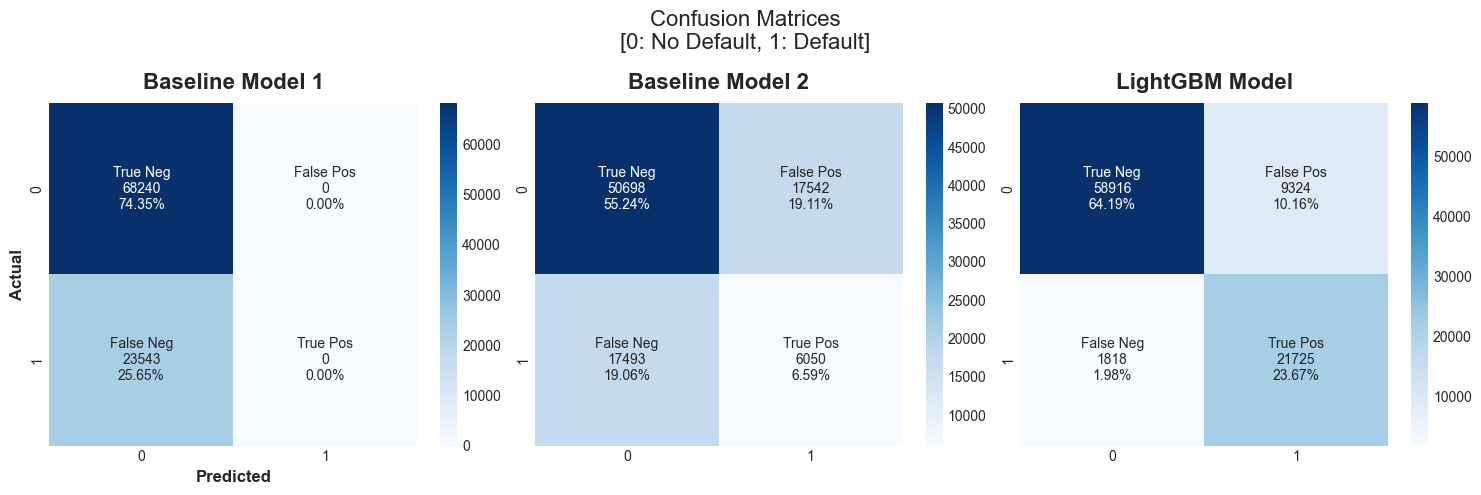

In [49]:
# calculate the confusion matrix for each model
cf_matrix_baseline_model_1 = confusion_matrix(y_test, baseline_model_1_predictions)
cf_matrix_baseline_model_2 = confusion_matrix(y_test, baseline_model_2_predictions)
cf_matrix_lightgbm_model = confusion_matrix(y_test, lightgbm_model_predictions_labels)

cf_matrices= [cf_matrix_baseline_model_1, cf_matrix_baseline_model_2, cf_matrix_lightgbm_model]
titles = ['Baseline Model 1', 'Baseline Model 2', 'LightGBM Model']

# create subplots for each confusion matrix 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# plot each confusion matrix
for i, ax in enumerate(axes):
    ax.set_title(titles[i])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    fig.suptitle('Confusion Matrices\n[0: No Default, 1: Default]', fontsize=16)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_cots = ['{0:0.0f}'.format(value) for value in cf_matrices[i].flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrices[i].flatten()/np.sum(cf_matrices[i])]

    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_cots,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)


    sns.heatmap(cf_matrices[i], annot=labels, fmt='', cmap='Blues', ax=ax)

plt.tight_layout()

# Matthew's Correlation Coefficient (MCC)

In [50]:
# calculate MCC for each model
baseline_model_1_mcc = metrics.matthews_corrcoef(y_test, baseline_model_1_predictions)
baseline_model_2_mcc = metrics.matthews_corrcoef(y_test, baseline_model_2_predictions)
lightgbm_model_mcc = metrics.matthews_corrcoef(y_test, lightgbm_model_predictions_labels)

print("Baseline Model 1 MCC: %f" % (baseline_model_1_mcc))
print("Baseline Model 2 MCC: %f" % (baseline_model_2_mcc))
print("LightGBM Model MCC: %f" % (lightgbm_model_mcc))

Baseline Model 1 MCC: 0.000000
Baseline Model 2 MCC: -0.000087
LightGBM Model MCC: 0.725626


# McNemar's Test

In [65]:
# calculate contingency table for each model
baseline_models_contingency_table = pd.crosstab(baseline_model_1_predictions, baseline_model_2_predictions)
lightgbm_baseline_model_1_contingency_table = pd.crosstab(lightgbm_model_predictions_labels, baseline_model_1_predictions)
lightgbm_baseline_model_2_contingency_table = pd.crosstab(lightgbm_model_predictions_labels, baseline_model_2_predictions)

# calculate McNemar's test for each model
baseline_models_mcnemar_test = mcnemar(baseline_models_contingency_table, exact=False, correction=True)
lightgbm_baseline_model_1_mcnemar_test = mcnemar(lightgbm_baseline_model_1_contingency_table, exact=False, correction=True)
lightgbm_baseline_model_2_mcnemar_test = mcnemar(lightgbm_baseline_model_2_contingency_table, exact=False, correction=True)

# summarize the finding
print('Baseline Models McNemar Test: chi-squared=%.3f, p-value=%.3f' % (baseline_models_mcnemar_test.statistic, baseline_models_mcnemar_test.pvalue))
print('LightGBM vs Baseline Model 1 McNemar Test: chi-squared=%.3f, p-value=%.3f' % (lightgbm_baseline_model_1_mcnemar_test.statistic, lightgbm_baseline_model_1_mcnemar_test.pvalue))
print('LightGBM vs Baseline Model 2 McNemar Test: chi-squared=%.3f, p-value=%.3f' % (lightgbm_baseline_model_2_mcnemar_test.statistic, lightgbm_baseline_model_2_mcnemar_test.pvalue))

Baseline Models McNemar Test: chi-squared=23590.000, p-value=0.000
LightGBM vs Baseline Model 1 McNemar Test: chi-squared=31047.000, p-value=0.000
LightGBM vs Baseline Model 2 McNemar Test: chi-squared=1437.784, p-value=0.000


In [64]:
# interpret the p-value
alpha = 0.05
if lightgbm_baseline_model_2_mcnemar_test.pvalue > alpha:
	print('Same proportions of errors (fail to reject H0)')
else:
	print('Different proportions of errors (reject H0)')

Different proportions of errors (reject H0)


# Summary
- Brier Score
    - Baseline Model 1: 0.256507
    - Baseline Model 2: 0.381716
    - LightGBM Model: 0.070000
- Matthews Correlation Coefficient
    - Baseline Model 1: 0.000000
    - Baseline Model 2: -0.000087
    - LightGBM Model: 0.725626
- McNemar's Test
    - Baseline Models McNemar Test 1: Different proportions of errors (reject H0)
    - LightGBM vs Baseline Model 1 McNemar Test: Different proportions of errors (reject H0)
    - LightGBM vs Baseline Model 2 McNemar Test: Different proportions of errors (reject H0)